In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
from keras.models import load_model
import itertools 
filterwarnings('ignore')
np.random.seed(101)
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Mon Aug 15 17:33:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
train_dir ="/content/drive/MyDrive/BC_Data/IHC/train_jpg"
val_dir = "/content/drive/MyDrive/BC_Data/IHC/test_jpg"
test_dir="/content/drive/MyDrive/BC_Data/IHC/test_jpg"
labels = ['0', '1', '2', '3']
label_np=np.array(labels)

In [5]:
import tensorflow as tf
import numpy as np
import os
import random


def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


seed = 101
set_seed(seed)

In [6]:
model1 = InceptionV3(include_top=False,input_shape=(224, 224,3), weights='imagenet')
input_shape = (224, 224)

In [7]:
datagen_train = ImageDataGenerator(rescale=1./255)

datagen_test = ImageDataGenerator(rescale=1./255)

datagen_val=ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,                                        
                                                    shuffle=True)

generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
generator_test=datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                 batch_size=batch_size,
                                                 shuffle=False)

Found 3896 images belonging to 4 classes.
Found 977 images belonging to 4 classes.
Found 977 images belonging to 4 classes.


In [8]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
# print_layer_trainable()

In [9]:
headModel = model1.output
headModel = layers.Flatten()(headModel)
#headModel = layers.GlobalAveragePooling2D()(headModel)
headModel = Dense(4, activation="softmax")(headModel)
model = Model(inputs=model1.input, outputs=headModel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['accuracy','Precision','Recall']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [11]:

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

earlystopping = EarlyStopping(monitor ="val_loss", 
                              mode ="min", patience = 3, 
                              restore_best_weights = True)
history = model.fit_generator(generator=generator_train,
                              epochs=50,
                              validation_data=generator_val,
                              validation_steps=steps_test,
                              callbacks =[earlystopping]
                              )


Epoch 1/50
244/244 [==============================] - 115s 407ms/step - loss: 1.2563 - accuracy: 0.4325 - precision: 0.4759 - recall: 0.2662 - val_loss: 1.0984 - val_accuracy: 0.5138 - val_precision: 0.5509 - val_recall: 0.3930
Epoch 2/50
244/244 [==============================] - 93s 382ms/step - loss: 0.9885 - accuracy: 0.5721 - precision: 0.6353 - recall: 0.4302 - val_loss: 0.9936 - val_accuracy: 0.5711 - val_precision: 0.6157 - val_recall: 0.4493
Epoch 3/50
244/244 [==============================] - 93s 380ms/step - loss: 0.8393 - accuracy: 0.6550 - precision: 0.7321 - recall: 0.5339 - val_loss: 0.9156 - val_accuracy: 0.5977 - val_precision: 0.6513 - val_recall: 0.4913
Epoch 4/50
244/244 [==============================] - 94s 386ms/step - loss: 0.6842 - accuracy: 0.7195 - precision: 0.7959 - recall: 0.6306 - val_loss: 0.8864 - val_accuracy: 0.6018 - val_precision: 0.6745 - val_recall: 0.4985
Epoch 5/50
244/244 [==============================] - 93s 381ms/step - loss: 0.5778 - accur

In [12]:
import nltk
import pickle
with open('/content/drive/MyDrive/BC_Weight/InceptionV3_TL_Flatten', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
np.save('/content/drive/MyDrive/BC_Weight/InceptionV3_TL_Flatten.npy',history.history)

In [13]:
model1.save("/content/drive/MyDrive/BC_Weight/InceptionV3_TL_Flatten.h5")

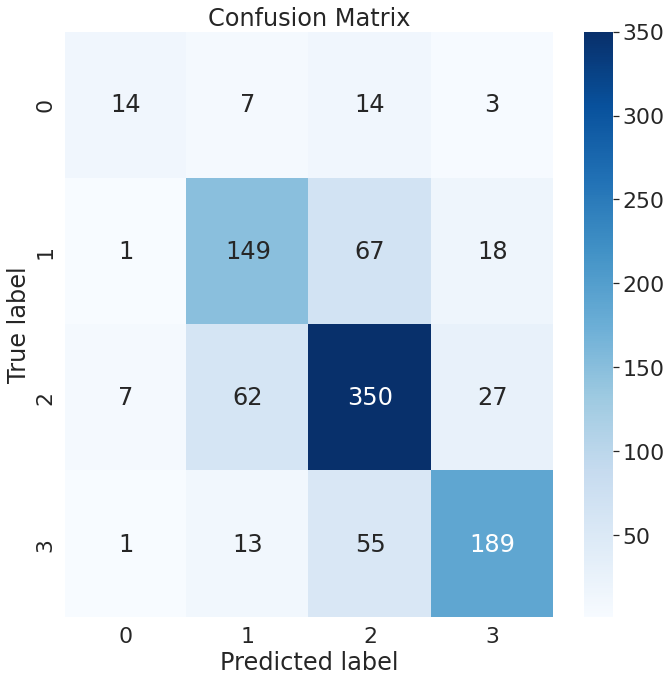

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(generator_test)
y_pred = np.argmax(Y_pred, axis=1)
array = confusion_matrix(generator_test.classes, y_pred)
df_cm = pd.DataFrame(array, index =['0', '1', '2', '3'],
                  columns = ['0', '1', '2', '3'])
plt.figure(figsize=(10,10))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('InceptionV3_confusion',dpi=200); 
plt.show()

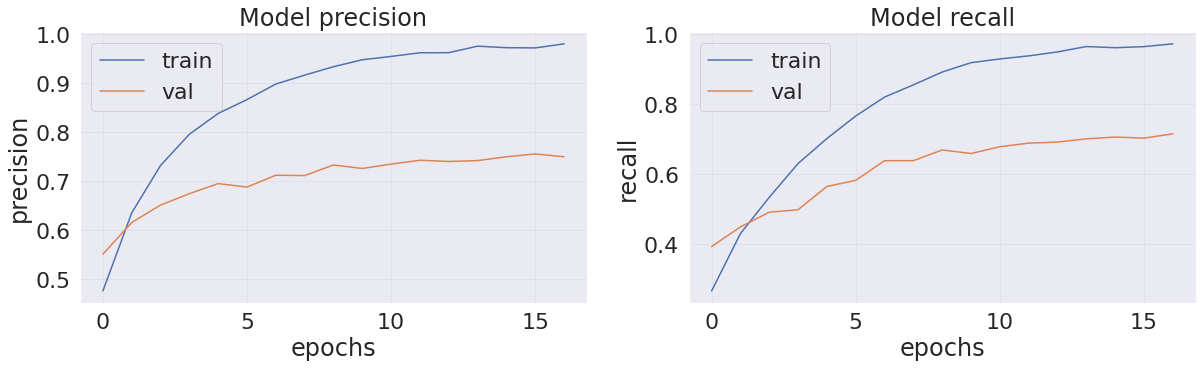

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'])

fig.savefig('model1_precision_recall',dpi=1200); 

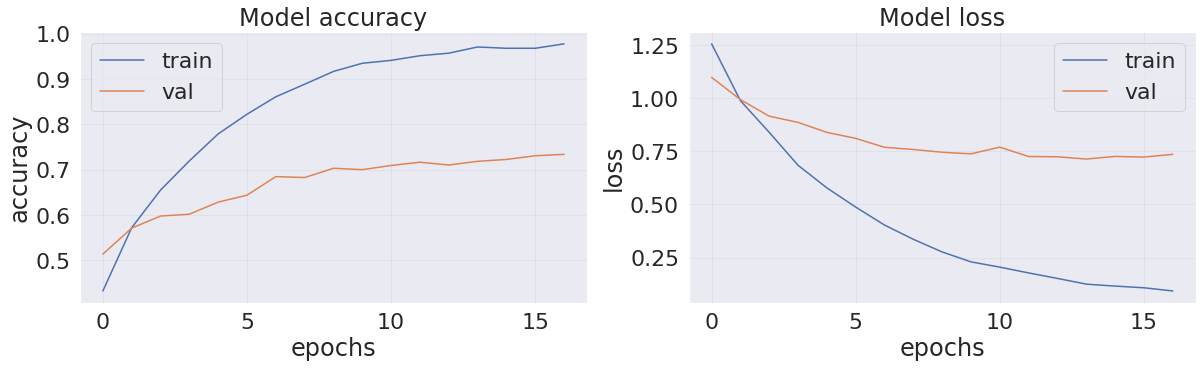

In [16]:

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
for i, met in enumerate([ 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'],loc='best')

fig.savefig('model1_accuracy_loss',dpi=1200); 

plt.show()